# HW №1
## Task 1

In [1]:
%%capture
!pip3 install qiskit

In [2]:
import numpy as np
import qiskit as qk

In [3]:
with open('./token', 'r') as token_file:
    token = token_file.read()

In [4]:
qk.IBMQ.save_account(token, overwrite = True)
qk.IBMQ.load_account()

/usr/local/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [5]:
provider = qk.IBMQ.get_provider(hub = 'ibm-q')

In [6]:
devices = provider.backends(filters=lambda x: (3 <= x.configuration().n_qubits <= 5) and not x.configuration().simulator)

In [7]:
real_backend = qk.providers.ibmq.least_busy(devices)
print(real_backend.configuration().n_qubits)

5


In [8]:
simd_backend = qk.Aer.get_backend('qasm_simulator')

## Task 2

Since we assume the following form of QBit wavefunction:
$\vert \psi \rangle = \sin \theta \vert 0 \rangle + \exp{i\varphi} \cos \theta \vert 1 \rangle$

Actually we measure kinda projection on $Z$ - axis that corresponds $\theta$ angle. Thus $\phi$ angle describes projection onto $X,~Y$ axes. To fix it we can rotate system (or alternavely Vector) in the following way: $X,~Y,~Z \rightarrow Z,~X,~Y$. To do this we should choose axis of rotation, obviously it is normalized vector $(1,~1,~1)$ and angle to rotate $\alpha = 2 \pi / 3$.

To make rotation itself we should compute corresponding axis. We know the form of such rotations (it can be derived from infinitesimal rotations): $\hat{R}_{\vec{n}} (\alpha)= e^{-i \vec{n} \cdot \hat{\vec{\sigma}} \alpha / 2}$.
Since all sigma's satisfy $\hat{\sigma}_i^2 = \hat{I}$ it can be rewritten in the following form: 

$$\hat{R}_{\vec{n}} (\alpha) = I \cos{\frac{\alpha}{2}} - i \vec{n} \cdot \hat{\vec{\sigma}} \sin{\frac{\alpha}{2}}$$

Thus the function to compute such operator is:

In [9]:
px = np.array([[0, 1 ], [1 , 0]], dtype = 'complex128')
py = np.array([[0,-1j], [1j, 0]], dtype = 'complex128')
pz = np.array([[1, 0 ], [0 ,-1]], dtype = 'complex128')
pi = np.array([[1, 0 ], [0 , 1]], dtype = 'complex128')

In [10]:
def rot_mat(vec, angle):
    assert len(vec) == 3
    lvec = np.array(vec, dtype = 'float64')
    lvec = lvec / np.linalg.norm(lvec)
    mat = lvec[0] * px + lvec[1] * py + lvec[2] * pz
    sq_mat = mat @ mat
    assert np.max(np.abs(sq_mat - pi)) < 1e-4
    res = pi * np.cos(angle / 2) - 1j * mat * np.sin(angle / 2)
    sq_res = np.conjugate(res).T @ res
    assert np.max(np.abs(sq_res - pi)) < 1e-4
    return res

We needs not general but specific rotation:

In [11]:
rot = rot_mat([1, 1, 1], 2 * np.pi / 3)

In [12]:
print(rot)

[[ 0.5-0.5j -0.5-0.5j]
 [ 0.5-0.5j  0.5+0.5j]]


We need to choose some random (but normalized) initial state:

In [13]:
state = np.random.rand(2) + 1j * np.random.rand(2)
state = state / np.linalg.norm(state)
psi_angle = np.angle(state[0])
state = np.exp(-1j * psi_angle) * state
assert np.imag(state[0]) < 1.e-4

Since here state has form: 
$\vert \psi \rangle = e^{i\psi} \sin \theta \vert 0 \rangle + e^{i\phi} \cos \theta \vert 1 \rangle$
We can rewrite in the following form:
$\vert \psi \rangle = e^{i\psi} (\sin \theta \vert 0 \rangle + \exp{i\varphi} \cos \theta \vert 1 \rangle)$, thus $\varphi = \phi - \psi$.

In [14]:
varphi = np.angle(state[1])

In [15]:
varphi

0.2774462277789017

In [16]:
q = qk.QuantumRegister(1)
c = qk.ClassicalRegister(1)
qc = qk.QuantumCircuit(q, c)
qc.initialize(state, q)
qc.unitary(rot, q)
qc.measure(q, c)
res = qk.execute(qc, backend = simd_backend, shots = 65536).result()
r0 = res.get_counts()

In [17]:
print(r0)

{'0': 41364, '1': 24172}


In [18]:
qc.draw()

┌──────────────────────────────────────┐┌─────────┐┌─┐
q0_0: ┤ initialize(0.65084,0.73018+0.20795j) ├┤ unitary ├┤M├
      └──────────────────────────────────────┘└─────────┘└╥┘
c0: 1/════════════════════════════════════════════════════╩═
                                                          0

Since we measure de-facto projection onto $Y$ axis:
$$\frac{p(0)}{p(1)} = 

In [19]:
phi = np.arctan(np.sqrt(r0['0'] / r0['1']))

In [20]:
phi

0.9181156856612727

In [40]:
npoints = 100
phis = np.linspace(-np.pi / 2, np.pi / 2, npoints)
rs, ps = np.zeros(npoints), np.zeros(npoints)
for i, phi in enumerate(phis):
    angles = np.array([1, np.exp(1j * phi)])
    state = np.random.rand(2)
    state = np.array(state) * angles
    state = state / np.linalg.norm(state)
    q = qk.QuantumRegister(1)
    c = qk.ClassicalRegister(1)
    qc = qk.QuantumCircuit(q, c)
    qc.initialize(state, q)
    qc.unitary(rot, q)
    qc.measure(q, c)
    res = qk.execute(qc, backend = simd_backend, shots = 262144).result()
    r0 = res.get_counts()
    rs[i] = r0['0'] / r0['1']
    ps[i] = np.arctan(np.sqrt(rs[i]))

In [22]:
import matplotlib.pyplot as plt

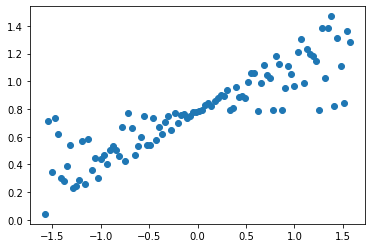

In [41]:

#plt.scatter(phis, rs)
plt.scatter(phis, ps)

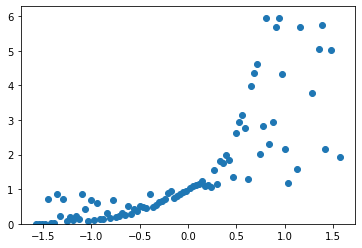

In [38]:
plt.ylim(0, 2 * np.pi)
plt.scatter(phis, rs)
#plt.scatter(phis, ps)